<a href="https://colab.research.google.com/github/ibex232/Two-cell-Half-center-Oscillator-Model/blob/main/ZEN7RC_CS4590_Modeling_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ZEN7RC CS4590 Modeling Project

This is a project completed for CS4590 by Zach Noah. Further details on this project can be viewed at the GitHub below within "Final Modeling Project-Zach Noah.pdf" file.


https://github.com/ibex232/Two-cell-Half-center-Oscillator-Model.git



The simulation can be run by either
1) Selectively running the "Simulation Initialization and GUI Code" then the simulation code block individually or
2) Clicking "Run all" at the top and wait for all of the code to finish running (this method will take longer due to parametric studies located past the simulation)

Various code in the github, namely the .mod files, were either adapted or borrowed from the example simulation provided by the professor. If these attributions are not reflected in the GitHub, please contact the GitHub owner immediately to have this fixed.

#Simulation Initialization and GUI Code

####Code setup

In [22]:
!pip install neuron

In [23]:
import os

if os.path.basename(os.getcwd())!='Two-cell-Half-center-Oscillator-Model':
  !git clone https://github.com/ibex232/Two-cell-Half-center-Oscillator-Model.git
  %cd Two-cell-Half-center-Oscillator-Model/

  print("\nCompilation status:")
  print(os.system('nrnivmodl'), "\n")
else:
  print('Mod files have already been downloaded.')
%ls



Mod files have already been downloaded.
capool.mod  HCO_cell_template.py  ka.mod   leak.mod      x86_64/
cas.mod     hyper.mod             kca.mod  na.mod
cat.mod     inhsyn.mod            kdr.mod  __pycache__/


In [24]:
from neuron import h
from HCO_cell_template import HCOCellTemplate
import matplotlib.pyplot as plt
import ipywidgets as widgets

h.load_file('stdrun.hoc')

h.dt = 0.025
h.v_init= -60

cellA = HCOCellTemplate()
cellB = HCOCellTemplate()

injectA = h.IClamp(cellA.soma(.5))
injectB = h.IClamp(cellB.soma(.5))

synA = h.inhsyn(.5,sec=cellA.soma)
synB = h.inhsyn(.5,sec=cellB.soma)

t_vec = h.Vector().record(h._ref_t)
iA_vec = h.Vector().record(synA._ref_isyn)
iB_vec = h.Vector().record(synB._ref_isyn)

nc_AB = h.NetCon(cellA.soma(0.5)._ref_v, synB, 0, 0, 10, sec=cellA.soma)
nc_BA = h.NetCon(cellB.soma(0.5)._ref_v, synA, 0, 0, 10, sec=cellB.soma)

####Eleak Check

In [25]:
print(cellB.soma.eleak)

-60.0


####General simulation parameters

In [26]:
h.tstop = 2000

Default_channel_param = [0.0002, 0.55, 0.20, 0.15, 0.02, 0.015, 0.02, 0.001, 80, 1]
Default_inject_param = [100, 50, 25, 0.5]
Default_syn_param = [-80, 0.2, 1, 12]

####Simulation setup

In [27]:
import numpy as np
from ipywidgets import interactive_output, HBox, VBox, Label, Layout
import matplotlib.gridspec as gridspec

channel_keys = [
        'gbar_leak', 'gbar_na', 'gbar_kdr', 'gbar_ka',
        'gbar_kca', 'gbar_cas', 'gbar_cat', 'gbar_hyper',
        'tauca_capool', 'fca_capool'
]

inject_keys = ['delay', 'dur', 'amp']
syn_keys   = ['esyn', 'gmax', 'tau1', 'tau2']


def run_sim(cell_params, inject_A_params, inject_B_params, syn_params):
  channel_param_packed = dict(zip(channel_keys, cell_params))
  inject_A_params_packed = dict(zip(inject_keys, inject_A_params))
  #inject_B_params_packed = dict(zip(inject_keys, inject_B_params))
  syn_params_packed = dict(zip(syn_keys, syn_params))

  cellA.v_vec = h.Vector().record(cellA.soma(0.5)._ref_v)
  cellB.v_vec = h.Vector().record(cellB.soma(0.5)._ref_v)

  for p,v in inject_A_params_packed.items():
      setattr(injectA,p,v)
  #for p,v in inject_B_params_packed.items():
      #setattr(injectB,p,v)

  cellA.set_biophysics(**channel_param_packed)
  cellB.set_biophysics(**channel_param_packed)

  for p,v in syn_params_packed.items():
    setattr(synA, p, v)
    setattr(synB, p, v)

  _ = h.run()

####Interactive plots and gui

In [28]:
def interactive_plot(**kwargs):
  cell_params = [kwargs[k] for k in ['w_gbar_leak','w_gbar_na','w_gbar_kdr','w_gbar_ka','w_gbar_kca',
                                      'w_gbar_cas','w_gbar_cat','w_gbar_hyper','w_tauca_capool','w_fca_capool']]
  inject_params = [kwargs[k] for k in ['w_inject_start','w_inject_dur','w_inject_offset','w_inject_amp']]
  syn_params = [kwargs[k] for k in ['w_esyn','w_gmax','w_tau1','w_tau2']]
  enable_all_graphs = kwargs['w_display_graphs']

  plt.close('all')

  run_sim(
    cell_params,

  [w_inject_start.value,
    w_inject_dur.value,
    w_inject_amp.value],

  [w_inject_start.value + w_inject_offset.value,
    w_inject_dur.value,
    w_inject_amp.value],

    syn_params)




  if (enable_all_graphs):
    fig = plt.figure(figsize=(12, 16))
    gs = gridspec.GridSpec(4, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, :])
    for i, cell in enumerate([cellA, cellB]): #for i, cell in enumerate([cellA]): #un-comment and replace left code with this loop for visualizing single-cell graphs
        cellname = 'Cell B' if i>0 else 'Cell A'
        clr = 'r' if i>0 else 'b'
        ax1.plot(cell.t,cell.record['v'],clr,label=cellname)
    ax1.set_xlim(cellA.t[0],cellA.t[-1])
    ax1.set_ylim(-90,60)
    ax1.legend(loc=1)
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Membrane Voltage (mV)')


    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(t_vec, iB_vec, color='b', label='A → B')
    ax2.plot(t_vec, iA_vec, color='r', label='B → A')
    ax2.set_title('Inhibitory Synaptic Currents')
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Current (nA)')
    ax2.grid(True)
    ax2.legend()

    sub_gs2 = gs[2:, 0].subgridspec(3, 1, hspace=0.75)
    ax3s = [fig.add_subplot(sub_gs2[i, 0]) for i in range(3)]
    cellA.plot_vars(cellid=0, axs=ax3s)

    sub_gs3 = gs[2:, 1].subgridspec(3, 1, hspace=0.75)
    ax4s = [fig.add_subplot(sub_gs3[i, 0]) for i in range(3)]
    cellB.plot_vars(cellid=1, axs=ax4s)
  else:
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, :])
    #ax1.figure(figsize=(10,4.8))
    for i, cell in enumerate([cellA, cellB]):
        cellname = 'Cell B' if i>0 else 'Cell A'
        clr = 'r' if i>0 else 'b'
        ax1.plot(cell.t,cell.record['v'],clr,label=cellname)
    ax1.set_xlim(cellA.t[0],cellA.t[-1])
    ax1.set_ylim(-90,60)
    ax1.legend(loc=1)
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Membrane Voltage (mV)')


    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(t_vec, iB_vec, color='b', label='A → B')
    ax2.plot(t_vec, iA_vec, color='r', label='B → A')
    ax2.set_title('Inhibitory Synaptic Currents')
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Current (nA)')
    ax2.grid(True)
    ax2.legend()


  plt.tight_layout(pad=5)
  plt.show()

In [29]:
xslider = Layout(width='500px')
yslider = Layout(height='350px')
w_reset = widgets.Button(
    description='Reset',
    icon='history',
    layout=widgets.Layout(
        width='400px',
        height='100px',
        padding='10px',
        margin='5px',
        border='2px solid black',
        background_color='#c493c4',
    ),
    style=widgets.ButtonStyle(
        button_color='#c493c4',
        font_weight='bold'
    )
)

w_gbar_leak = widgets.FloatSlider(value=Default_channel_param[0], min=0, max=0.001, step=0.0001, description='Leak', continuous_update=False, readout_format='.4f')
w_gbar_na = widgets.FloatSlider(value=Default_channel_param[1], min=0.1, max=0.6, step=0.01, description='Na', continuous_update=False)
w_gbar_kdr = widgets.FloatSlider(value=Default_channel_param[2], min=0.1, max=0.5, step=0.01, description='Kdr', continuous_update=False)
w_gbar_ka = widgets.FloatSlider(value=Default_channel_param[3], min=0.1, max=0.5, step=0.01, description='Ka', continuous_update=False)
w_gbar_kca = widgets.FloatSlider(value=Default_channel_param[4], min=0.01, max=0.1, step=0.001, description='KCa', continuous_update=False, readout_format='.3f')
w_gbar_cas = widgets.FloatSlider(value=Default_channel_param[5], min=0.001, max=0.02, step=0.001, description='CaS', continuous_update=False, readout_format='.3f')
w_gbar_cat = widgets.FloatSlider(value=Default_channel_param[6], min=0.005, max=0.05, step=0.001, description='CaT', continuous_update=False, readout_format='.3f')
w_gbar_hyper = widgets.FloatSlider(value=Default_channel_param[7], min=0.0001, max=0.002, step=0.0001, description='Hyper', continuous_update=False, readout_format='.4f')
w_tauca_capool = widgets.FloatSlider(value=Default_channel_param[8], min=1, max=100, step=1, description='TauCa', continuous_update=False)
w_fca_capool = widgets.FloatSlider(value=Default_channel_param[9], min=0, max=3, step=0.1, description='FCa', continuous_update=False)

w_inject_start = widgets.FloatSlider(value=Default_inject_param[0], min=0, max=500, step=1, description='Start', continuous_update=False)
w_inject_dur = widgets.FloatSlider(value=Default_inject_param[1], min=10, max=2000, step=1, description='Duration', continuous_update=False)
w_inject_offset = widgets.FloatSlider(value=(Default_inject_param[2]), min=0, max=100, step=1, description='A → B offset', continuous_update=False)
w_inject_amp = widgets.FloatSlider(value=Default_inject_param[3], min=0.1, max=2, step=0.1, description='Amplitude', continuous_update=False)

w_esyn = widgets.FloatSlider(value=Default_syn_param[0], min=-100, max=-60, step=1, description='ESyn', continuous_update=False)
w_gmax = widgets.FloatSlider(value=Default_syn_param[1], min=0, max=1, step=0.01, description='gMax', continuous_update=False)
w_tau1 = widgets.FloatSlider(value=Default_syn_param[2], min=0, max=15, step=1, description='Tau1', continuous_update=False)
w_tau2 = widgets.FloatSlider(value=Default_syn_param[3], min=0, max=35, step=1, description='Tau2', continuous_update=False)
w_display_graphs = widgets.Checkbox(vale=False, description='Display cell-specific graphs', indent=False)

controls = {
    'w_gbar_leak': w_gbar_leak,
    'w_gbar_na': w_gbar_na,
    'w_gbar_kdr': w_gbar_kdr,
    'w_gbar_ka': w_gbar_ka,
    'w_gbar_kca': w_gbar_kca,
    'w_gbar_cas': w_gbar_cas,
    'w_gbar_cat': w_gbar_cat,
    'w_gbar_hyper': w_gbar_hyper,
    'w_tauca_capool': w_tauca_capool,
    'w_fca_capool': w_fca_capool,
    'w_inject_start': w_inject_start,
    'w_inject_dur': w_inject_dur,
    'w_inject_offset': w_inject_offset,
    'w_inject_amp': w_inject_amp,
    'w_esyn': w_esyn,
    'w_gmax': w_gmax,
    'w_tau1': w_tau1,
    'w_tau2': w_tau2,
    'w_display_graphs': w_display_graphs
}


In [30]:
def interactive_plot_wrapper(*args, **kwargs):
  set_status("Simulating...")
  try:
    interactive_plot(*args, **kwargs)
  finally:
    set_status("Idle")


def set_status(status="Idle"):
    color = "green" if status == "Idle" else "yellow"
    status_indicator.value = f"""
    <div style="
        width: 380px;
        padding: 10px;
        margin: 5px;
        border: 2px solid black;
        background-color: {color};
        text-align: center;
        font-size: 20px;
        font-weight: bold;
    ">
        {status}
    </div>
    """

interactive_obj = widgets.interactive(interactive_plot_wrapper, **controls)
out = interactive_obj.children[-1]


def pause_interactive_output():
    for w in controls.values():
        w.unobserve(interactive_obj.update, names='value')

def resume_interactive_output():
    for w in controls.values():
        w.observe(interactive_obj.update, names='value')


def reset_default(*args):
  pause_interactive_output()

  all_defaults = (
      list(Default_channel_param[:]) +
      list(Default_inject_param[:]) +
      list(Default_syn_param[:])
  )

  for widget, value in zip(controls.values(), all_defaults):
    widget.value = value

  resume_interactive_output()
  interactive_obj.update()


w_reset.on_click(reset_default)


In [31]:
channel_parameter_box = VBox([
        w_gbar_leak,
        w_gbar_na,
        w_gbar_kdr,
        w_gbar_ka,
        w_gbar_kca,
        w_gbar_cas,
        w_gbar_cat,
        w_gbar_hyper,
        w_tauca_capool,
        w_fca_capool
    ])

injection_parameters_box = VBox([
        w_inject_start,
        w_inject_dur,
        w_inject_offset,
        w_inject_amp
    ])

synapse_parameters_box = VBox([
        w_esyn,
        w_gmax,
        w_tau1,
        w_tau2
      ])

status_indicator = widgets.HTML(
    value="""
    <div style="
        width: 380px;
        padding: 10px;
        margin: 5px;
        border: 2px solid black;
        background-color: yellow;
        text-align: center;
        font-size: 20px;
        font-weight: bold;
    ">
        Simulating...
    </div>
    """
)


channel_label = widgets.HTML(
    value="""
    <div style="
        width: 380px;
        padding: 10px;
        margin: 5px;
        border: 2px solid black;
        background-color: #c493c4;
        text-align: center;
        font-size: 20px;
        font-weight: bold;
    ">
        Channel Parameters
    </div>
    """
)

injection_label = widgets.HTML(
    value="""
    <div style="
        width: 380px;
        padding: 10px;
        margin: 5px;
        border: 2px solid black;
        background-color: #c493c4;
        text-align: center;
        font-size: 20px;
        font-weight: bold;
    ">
        Injection Parameters
    </div>
    """
)

synapse_label = widgets.HTML(
    value="""
    <div style="
        width: 380px;
        padding: 10px;
        margin: 5px;
        border: 2px solid black;
        background-color: #c493c4;
        text-align: center;
        font-size: 20px;
        font-weight: bold;
    ">
        Synapse Parameters
    </div>
    """
)

interparameters_box_layout = widgets.Layout(
    border='2px solid black',
    background_color='#e09df5',
    padding='10px',
    margin='5px',
    width='400px'
)

channel_parameter_box.layout = interparameters_box_layout
injection_parameters_box.layout = interparameters_box_layout
synapse_parameters_box.layout = interparameters_box_layout


#Neuron Simulation

*NOTE: If you "Run all" at the beginning, the parameter sweep code in the next section will automatically run before this simulation can properly respond to updates, to fix this simply wait for that code to finish or manually interrupt it before using simulation*

In [11]:
parameters_ui = HBox([
    VBox([channel_label, channel_parameter_box]),
    VBox([injection_label, injection_parameters_box, w_reset, status_indicator]),
    VBox([synapse_label, synapse_parameters_box, w_display_graphs])
    ])

ui = VBox([parameters_ui, out])
interactive_obj.update()
display(ui)

#Parameter Sweeps

##Setup

In [12]:
def compute_burst_frequency(v_trace, t_trace,
                                   threshold=-20,
                                   min_ibi_ms=250,
                                   min_bursts=3,
                                   min_amplitude=5):

    v = np.array(v_trace)
    t = np.array(t_trace)

    if (v.max() - v.min()) < min_amplitude:
        return 0.0

    raw_cross = np.where((v[:-1] < threshold) & (v[1:] >= threshold))[0]
    if len(raw_cross) == 0:
        return 0.0

    times = t[raw_cross]

    bursts = [times[0]]
    for tt in times[1:]:
        if tt - bursts[-1] >= min_ibi_ms:
            bursts.append(tt)

    bursts = np.array(bursts)

    if len(bursts) < min_bursts:
        return 0.0

    ibi = np.diff(bursts)
    mean_period = np.mean(ibi)

    if mean_period < min_ibi_ms:
        return 0.0

    return 1000.0 / mean_period


## GSyn sweep

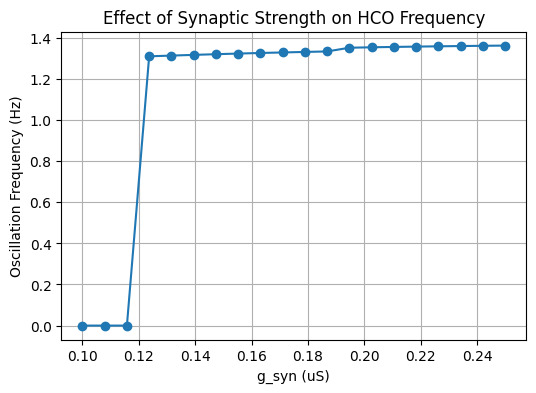

In [13]:
def sweep_gsyn(values):
    freqs = []
    for g in values:
        syn_params = Default_syn_param.copy()
        syn_params[1] = g

        run_sim(Default_channel_param,
                Default_inject_param,
                Default_inject_param,
                syn_params)

        fA = compute_burst_frequency(cellA.v_vec, t_vec)
        freqs.append(fA)
    return np.array(freqs)

def plot_gsyn_sweep():
    gs = np.linspace(0.1, 0.25, 20)
    freqs = sweep_gsyn(gs)

    plt.figure(figsize=(6,4))
    plt.plot(gs, freqs, '-o')
    plt.xlabel("g_syn (uS)")
    plt.ylabel("Oscillation Frequency (Hz)")
    plt.title("Effect of Synaptic Strength on HCO Frequency")
    plt.grid(True)
    plt.show()

plot_gsyn_sweep()

## Na Sweep

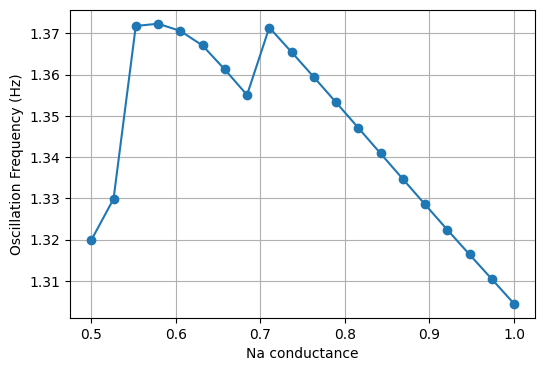

In [14]:
def sweep_na(values):
    freqs = []
    for na in values:
        channel_params = Default_channel_param.copy()
        channel_params[1] = na

        run_sim(channel_params,
                Default_inject_param,
                Default_inject_param,
                Default_syn_param)

        fA = compute_burst_frequency(cellA.v_vec, t_vec)
        freqs.append(fA)
    return np.array(freqs)

def plot_na_sweep():
    nas = np.linspace(0.5, 1, 20)
    freqs = sweep_na(nas)

    plt.figure(figsize=(6,4))
    plt.plot(nas, freqs, '-o')
    plt.xlabel("Na conductance")
    plt.ylabel("Oscillation Frequency (Hz)")
    plt.grid(True)
    plt.show()

plot_na_sweep()

##Leak sweep


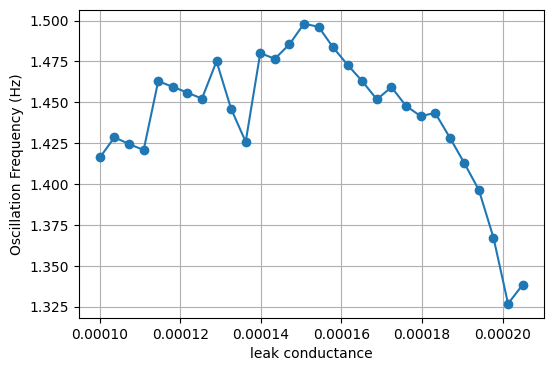

In [15]:
def sweep_leak(values):
    freqs = []
    for v in values:
        channel_params = Default_channel_param.copy()
        channel_params[0] = v

        run_sim(channel_params,
                Default_inject_param,
                Default_inject_param,
                Default_syn_param)

        fA = compute_burst_frequency(cellA.v_vec, t_vec, min_ibi_ms=500)
        freqs.append(fA)
    return np.array(freqs)

def plot_leak_sweep():
    leaks = np.linspace(0.0001, 0.000205, 30)
    freqs = sweep_leak(leaks)

    plt.figure(figsize=(6,4))
    plt.plot(leaks, freqs, '-o')
    plt.xlabel("leak conductance")
    plt.ylabel("Oscillation Frequency (Hz)")
    plt.grid(True)
    plt.show()

plot_leak_sweep()

##Kdr sweep

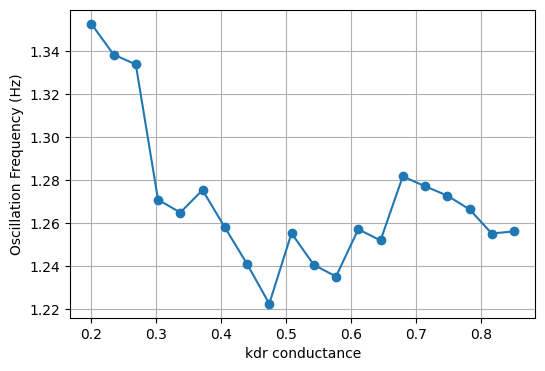

In [16]:
def sweep_kdr(values):
    freqs = []
    for v in values:
        channel_params = Default_channel_param.copy()
        channel_params[2] = v

        run_sim(channel_params,
                Default_inject_param,
                Default_inject_param,
                Default_syn_param)

        fA = compute_burst_frequency(cellA.v_vec, t_vec, min_ibi_ms=450)
        freqs.append(fA)
    return np.array(freqs)

def plot_kdr_sweep():
    kdrs = np.linspace(0.2, 0.85, 20)
    freqs = sweep_kdr(kdrs)

    plt.figure(figsize=(6,4))
    plt.plot(kdrs, freqs, '-o')
    plt.xlabel("kdr conductance")
    plt.ylabel("Oscillation Frequency (Hz)")
    plt.grid(True)
    plt.show()

plot_kdr_sweep()

##Ka sweep

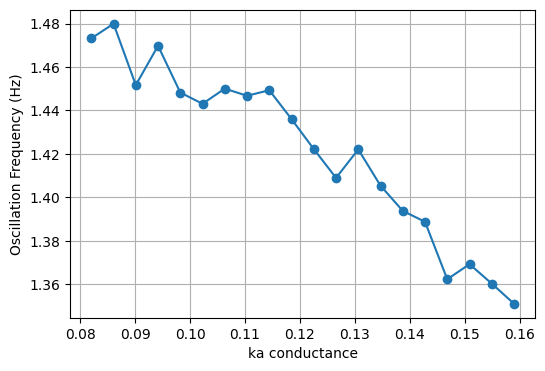

In [17]:
def sweep_ka(values):
    freqs = []
    for v in values:
        channel_params = Default_channel_param.copy()
        channel_params[3] = v

        run_sim(channel_params,
                Default_inject_param,
                Default_inject_param,
                Default_syn_param)

        fA = compute_burst_frequency(cellA.v_vec, t_vec, min_ibi_ms=450)
        freqs.append(fA)
    return np.array(freqs)

def plot_ka_sweep():
    kas = np.linspace(0.082, 0.159, 20)
    freqs = sweep_ka(kas)

    plt.figure(figsize=(6,4))
    plt.plot(kas, freqs, '-o')
    plt.xlabel("ka conductance")
    plt.ylabel("Oscillation Frequency (Hz)")
    plt.grid(True)
    plt.show()

plot_ka_sweep()

##KCa sweep

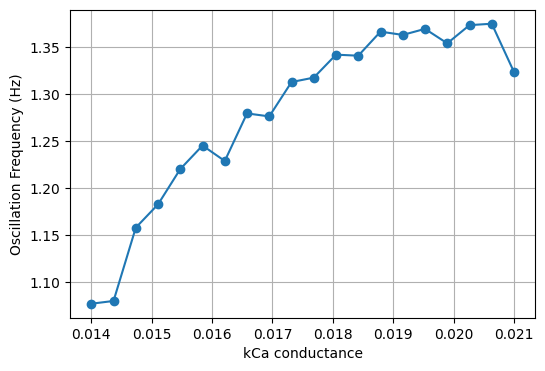

In [18]:
def sweep_kCa(values):
    freqs = []
    for v in values:
        channel_params = Default_channel_param.copy()
        channel_params[4] = v

        run_sim(channel_params,
                Default_inject_param,
                Default_inject_param,
                Default_syn_param)

        fA = compute_burst_frequency(cellA.v_vec, t_vec, min_ibi_ms=400)
        freqs.append(fA)
    return np.array(freqs)

def plot_kCa_sweep():
    kCas = np.linspace(0.014, 0.021, 20)
    freqs = sweep_kCa(kCas)

    plt.figure(figsize=(6,4))
    plt.plot(kCas, freqs, '-o')
    plt.xlabel("kCa conductance")
    plt.ylabel("Oscillation Frequency (Hz)")
    plt.grid(True)
    plt.show()

plot_kCa_sweep()

##CaS sweep

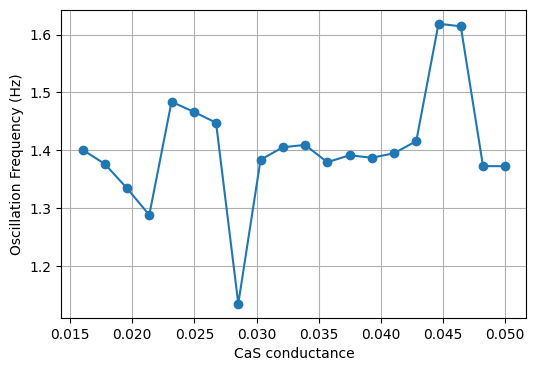

In [19]:
def sweep_CaS(values):
    freqs = []
    for v in values:
        channel_params = Default_channel_param.copy()
        channel_params[5] = v

        run_sim(channel_params,
                Default_inject_param,
                Default_inject_param,
                Default_syn_param)

        fA = compute_burst_frequency(cellA.v_vec, t_vec, min_ibi_ms=300)
        freqs.append(fA)
    return np.array(freqs)

def plot_CaS_sweep():
    CaSs = np.linspace(0.016, 0.05, 20)
    freqs = sweep_CaS(CaSs)

    plt.figure(figsize=(6,4))
    plt.plot(CaSs, freqs, '-o')
    plt.xlabel("CaS conductance")
    plt.ylabel("Oscillation Frequency (Hz)")
    plt.grid(True)
    plt.show()

plot_CaS_sweep()

##CaT sweep

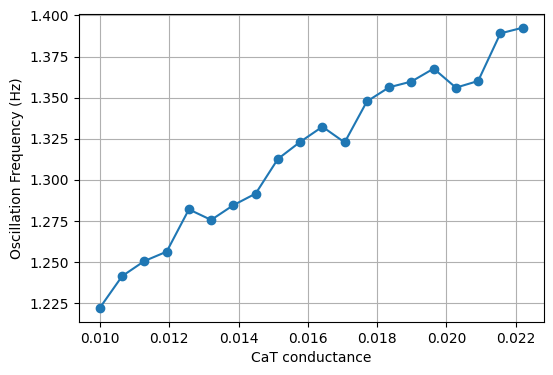

In [20]:
def sweep_CaT(values):
    freqs = []
    for v in values:
        channel_params = Default_channel_param.copy()
        channel_params[6] = v

        run_sim(channel_params,
                Default_inject_param,
                Default_inject_param,
                Default_syn_param)

        fA = compute_burst_frequency(cellA.v_vec, t_vec, min_ibi_ms=450)
        freqs.append(fA)
    return np.array(freqs)

def plot_CaT_sweep():
    CaTs = np.linspace(0.01, 0.0222, 20)
    freqs = sweep_CaT(CaTs)

    plt.figure(figsize=(6,4))
    plt.plot(CaTs, freqs, '-o')
    plt.xlabel("CaT conductance")
    plt.ylabel("Oscillation Frequency (Hz)")
    plt.grid(True)
    plt.show()

plot_CaT_sweep()

##Hyper sweep

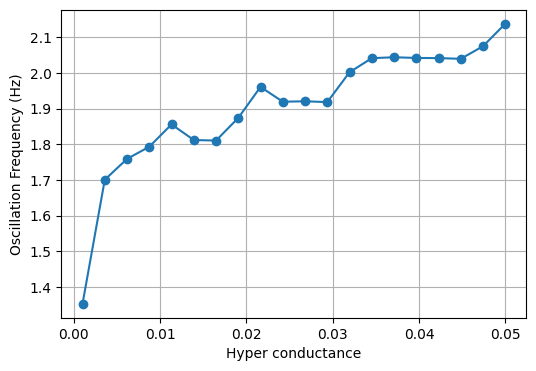

In [21]:
def sweep_Hyper(values):
    freqs = []
    for v in values:
        channel_params = Default_channel_param.copy()
        channel_params[7] = v

        run_sim(channel_params,
                Default_inject_param,
                Default_inject_param,
                Default_syn_param)

        fA = compute_burst_frequency(cellA.v_vec, t_vec, min_ibi_ms=350)
        freqs.append(fA)
    return np.array(freqs)

def plot_Hyper_sweep():
    Hypers = np.linspace(0.001, 0.05, 20)
    freqs = sweep_Hyper(Hypers)

    plt.figure(figsize=(6,4))
    plt.plot(Hypers, freqs, '-o')
    plt.xlabel("Hyper conductance")
    plt.ylabel("Oscillation Frequency (Hz)")
    plt.grid(True)
    plt.show()

plot_Hyper_sweep()